In [10]:
import sys
import math
import numpy as np
import scipy.optimize as optimize

AE_ROOT = '/media/sf_Masterarbeit/data/ILSVRC2012_img_train_AE_50'

all_success_progress = np.load(AE_ROOT + '/' + 'success_progress.npy')
all_failure_progress = np.load(AE_ROOT + '/' + 'failure_progress.npy')

TRAINING_POINT_PORTION = 0.4
NUM_TRAINING_POINTS = int(round( all_success_progress.shape[1] * TRAINING_POINT_PORTION ))
INITIAL_PARAMS = np.array([0.01, 300.0])

print('Using {0} out of {1} data points for training'.format(NUM_TRAINING_POINTS, all_success_progress.shape[1]))

Using 200 out of 500 data points for training


In [2]:
#def sigmoid(x, params):
#    return 1.0 / (1 + np.exp(-params[0] * (x - params[1])))
#
#def residuals(params, y, x):
#    return y - sigmoid(x, params)

In [3]:
x_range = np.arange(1, all_success_progress.shape[1] + 1)

#def fit_sigmoid(data, x_range):
#    all_params = np.empty(shape=(data.shape[0], 2))
#    
#    for index, row in enumerate(data):
#        plsq = optimize.leastsq(residuals, INITIAL_PARAMS, args=(row, x_range)) #TODO diag scale
#        all_params[index, ...] = plsq[0]
#    
#    return all_params
#
#all_success_params = fit_sigmoid(all_success_progress[:,:NUM_TRAINING_POINTS], x_range[:NUM_TRAINING_POINTS])
#all_failure_params = fit_sigmoid(all_failure_progress[:,:NUM_TRAINING_POINTS], x_range[:NUM_TRAINING_POINTS])

In [30]:
def sigmoid(x, alpha, t0):
    return 1.0 / (1 + np.exp(-alpha * (x - t0)))

def fit_sigmoid(data, x_range):
    all_params = np.empty(shape=(data.shape[0], 2))
    
    for index, row in enumerate(data):
        try:
            popt, pvoc = optimize.curve_fit(sigmoid, x_range, row, INITIAL_PARAMS, ftol=1.0e-16, maxfev=10000)
            all_params[index, ...] = popt
        except RuntimeError:
            all_params[index, ...] = np.zeros(shape=(2))
            sys.stderr.write('Runtime error on datapoint {0}'.format(index))
            
    
    return all_params

print('Fitting on successful runs')
all_success_params = fit_sigmoid(all_success_progress[:,:NUM_TRAINING_POINTS], x_range[:NUM_TRAINING_POINTS])
print('Fitting on failed runs')
all_failure_params = fit_sigmoid(all_failure_progress[:,:NUM_TRAINING_POINTS], x_range[:NUM_TRAINING_POINTS])

Fitting on successful runs
Fitting on failed runs


In [31]:
def predict(all_params, x_range):
    predictions = np.empty(shape=(all_params.shape[0], x_range.size))
    
    for pred, params in zip(predictions, all_params):
        pred[...] = np.array([sigmoid(x, *params) for x in x_range])
    
    return predictions

# Predict on all x values
all_success_predictions = predict(all_success_params, x_range)
all_failure_predictions = predict(all_failure_params, x_range)

def calc_mse(all_predictions, all_progress):
    diff = all_predictions - all_progress
    return np.mean(diff**2)

# Calculate MSE only on test data
success_mse = calc_mse(all_success_predictions[:, NUM_TRAINING_POINTS:], all_success_progress[:, NUM_TRAINING_POINTS:])
failure_mse = calc_mse(all_failure_predictions[:, NUM_TRAINING_POINTS:], all_failure_progress[:, NUM_TRAINING_POINTS:])

print('MSE over SUCCESSFUL samples and data points:\t{0}'.format(success_mse))
print('MSE over FAILED samples and data points:\t{0}'.format(failure_mse))

MSE over SUCCESSFUL samples and data points:	0.0402845023347
MSE over FAILED samples and data points:	0.0109556228523


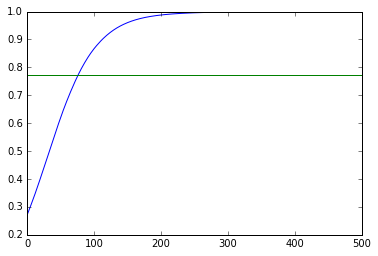

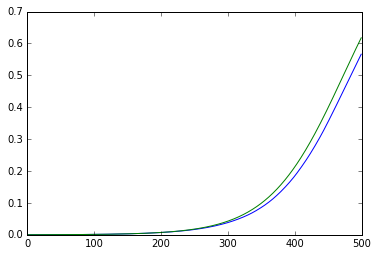

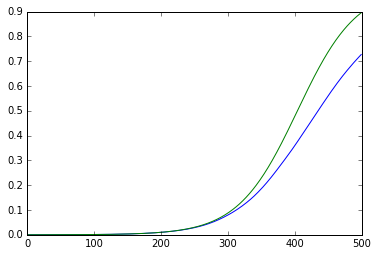

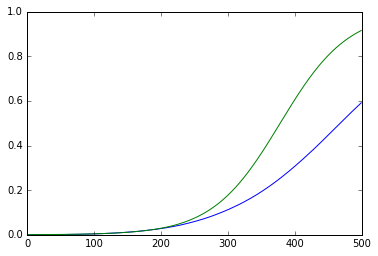

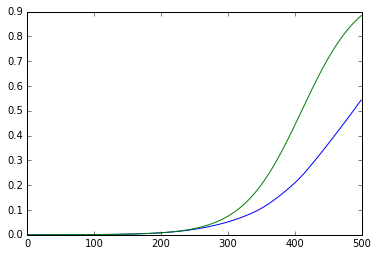

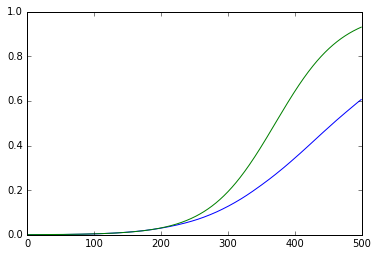

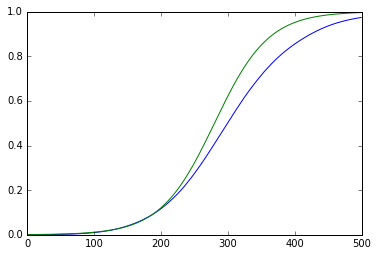

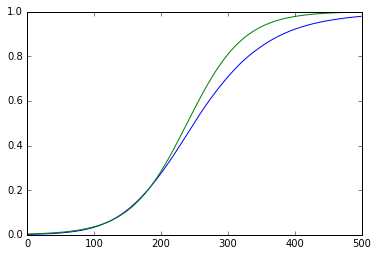

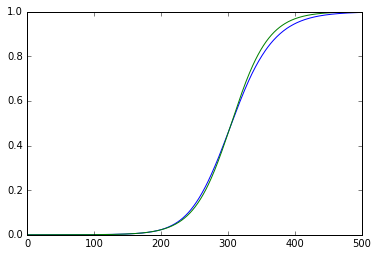

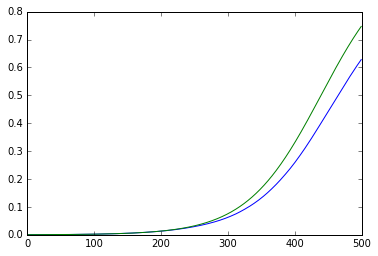

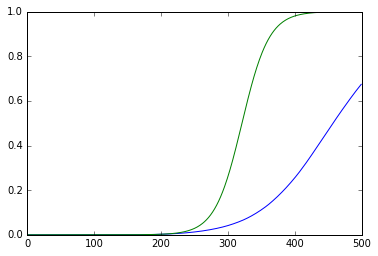

In [29]:
import matplotlib.pyplot as ppt
%matplotlib inline

indices = range(0, 10+1)
for index in indices:
    ppt.figure()
    ppt.plot(all_success_progress[index])
    ppt.plot(all_success_predictions[index])